In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# read csv from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
path = '/content/drive/MyDrive/cs534_music_classification/Data/features_3_sec.csv'
df = pd.read_csv(path)
df
final_data=df

In [ ]:
data_path_3 = "/content/drive/MyDrive/cs534_music_classification/stft_chromogram_zerocrossing.json" 
with open(data_path_3, "r") as f:
    data2 = json.load(f)
data2.keys()

dict_keys(['mapping', 'features', 'labels'])

In [ ]:
X_chroma = np.array(data2["features"])
X_chroma.shape

(9996, 130, 18)

In [ ]:
import json
import numpy as np
data_path_1 = "/content/drive/MyDrive/cs534_music_classification/data_extended_2.json" 
# data_path_2 = "/content/drive/MyDrive/cs534_music_classification/data_extended_chroma.json" 
data_path_2 = "/content/drive/MyDrive/cs534_music_classification/stft_chromogram_zerocrossing.json" 
def load_dataset(data_path_1, data_path_2):
    with open(data_path_1, "r") as f:
        data = json.load(f)
    with open(data_path_2, "r") as f:
        data2 = json.load(f)
    X_mfcc = np.array(data["mfcc"])
    X_chroma = np.array(data2["features"])
    y = np.array(data["labels"])
    
    X = np.concatenate((X_mfcc,X_chroma), axis=2)
    return X, y
X, y = load_dataset(data_path_1, data_path_2) 

In [ ]:
X.shape

(9996, 130, 58)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=534)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.222, random_state=534)

input_shape = (x_train.shape[1], x_train.shape[2])

In [ ]:
x_train.shape

(6998, 130, 58)

In [ ]:
input_shape

(130, 58)

In [ ]:
#The loss is calculated using sparse_categorical_crossentropy function
def trainModel(model, epochs, optimizer):
    batch_size = 128
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                   metrics='accuracy'
    )
    return model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, 
                     batch_size=batch_size)

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential()
# model.add(tf.keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
# model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True), input_shape=input_shape))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
)
model.summary()
callbacks = [tf.keras.callbacks.ModelCheckpoint(
                filepath="lstm.keras",
                save_best_only=True,
                monitor="val_loss")]

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), callbacks=callbacks, batch_size=32, epochs=100, verbose=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 130, 128)         62976     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 170,698
Trainable params: 170,698
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
219/219 - 26s - loss: 1.8092 - accurac

0.84, 53 coeffcients

In [ ]:
print(set(y_train))
test_model = tf.keras.models.load_model("lstm.keras")
test_loss, test_acc = test_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc: .3f}")
y_pred = test_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
acc =accuracy_score(y_test, y_pred)
print(acc)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
32/32 [==============================] - 2s 15ms/step - loss: 0.8992 - accuracy: 0.7080
Test Accuracy:  0.708
32/32 [==============================] - 2s 11ms/step
0.708


In [ ]:
# Run the next block first
from matplotlib import pyplot as plt
cc = class_counter(y_test)
cc.count(y_test, y_pred)
cc.accuracy()

mapping = ['pop', 'metal', 'disco', 'blues', 'reggae', 'classical', 'rock', 'hiphop', 'country', 'jazz']
plt.figure(figsize=(18, 12))
plt.title("Accuracy by Genre", fontsize=15)
plt.xlabel("Genre")
plt.ylabel("Accuracy")
plt.bar(mapping, cc.acc)
plt.xticks(fontsize=15)
plt.show()

In [ ]:
# Object to count number of correct prediction for each class
class class_counter():
  def __init__(self, label):
    self.l = len(set(label))
    self.correct = np.array([0]*self.l)
    self.total = np.array([0]*self.l)
    self.acc = 0
    self.total_acc = 0

  # count the number of correct and total for each class
  def count(self, y_true, y_pred):
    if y_true.shape != y_pred.shape:
      print("Dimension mismatch")
    for i in range(len(y_true)):
      self.total[y_true[i]] += 1
      if y_true[i] == y_pred[i]:
        self.correct[y_true[i]] += 1
    self.acc = self.correct/self.total
    self.total_acc = sum(self.correct)/sum(self.total)

  # print and return total accuracy and accuracy by class
  def accuracy(self):
    print("Total accuracy: ", self.total_acc.tolist())
    print("Accuracy by class: ", self.acc.tolist())
    return self.total_acc, self.acc

Total accuracy:  0.708
Accuracy by class:  [0.7821782178217822, 0.6808510638297872, 0.7456140350877193, 0.8518518518518519, 0.6666666666666666, 0.8725490196078431, 0.4823529411764706, 0.6288659793814433, 0.5588235294117647, 0.7578947368421053]


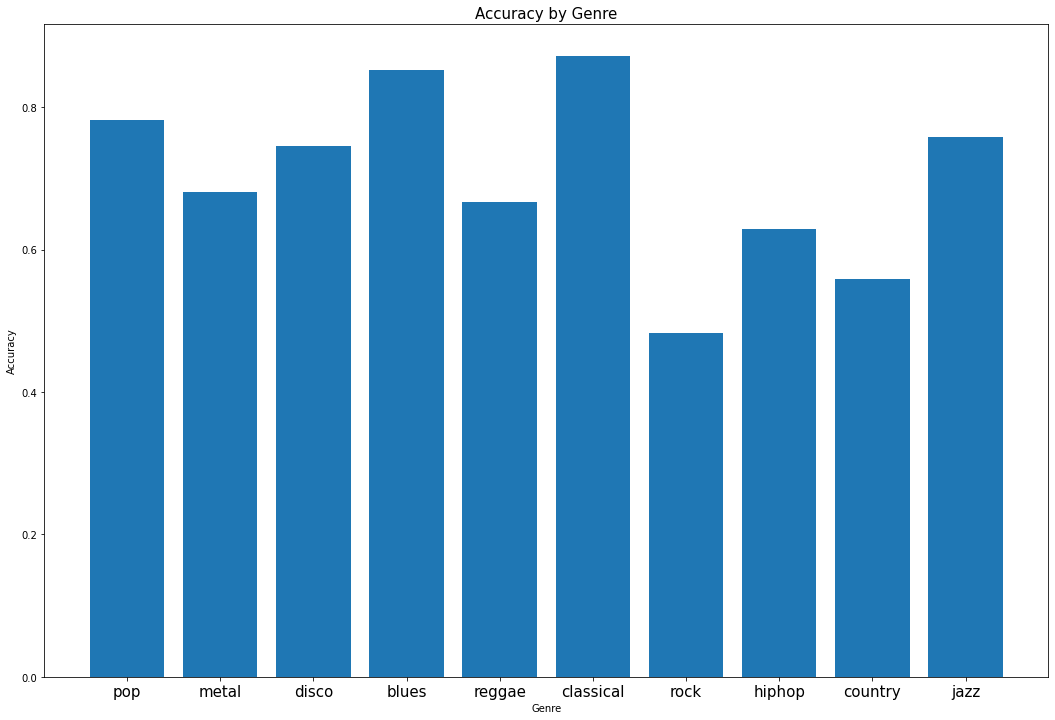

In [ ]:
from matplotlib import pyplot as plt
cc = class_counter(y_test)
cc.count(y_test, y_pred)
cc.accuracy()

mapping = ['pop', 'metal', 'disco', 'blues', 'reggae', 'classical', 'rock', 'hiphop', 'country', 'jazz']
plt.figure(figsize=(18, 12))
plt.title("Accuracy by Genre", fontsize=15)
plt.xlabel("Genre")
plt.ylabel("Accuracy")
plt.bar(mapping, cc.acc)
plt.xticks(fontsize=15)
plt.show()

In [ ]:
x_train.shape

(5997, 130, 40)

In [ ]:
x_test.shape

(2499, 130, 40)

In [ ]:
y_test.shape

(1250,)

In [ ]:
x_test[1]

array([[-214.41519165,  120.9526825 ,   31.03624153, ...,   -1.54931927,
          -4.25996065,   -1.34310222],
       [-111.19458771,  122.84535217,   21.36351395, ...,   -1.10229135,
          -4.47318077,   -2.04023671],
       [-103.87045288,  117.05361938,   34.44298172, ...,   -3.28001118,
          -4.01896381,   -5.77505922],
       ...,
       [ -39.80409622,   81.95127869,   14.91711521, ...,    8.31564426,
          12.54940414,    7.17934084],
       [ -67.63655853,   87.12245178,    9.90473366, ...,   10.55561543,
           9.33628082,   -7.21052217],
       [-105.74510956,  105.83744812,   10.22558212, ...,   10.1876564 ,
           5.75561857,  -12.49080944]])

In [ ]:
y_test.shape[0] + y_train.shape[0] + y_val.shape[0]

9996